# EDA for US House 1981-2016

This notebook includes exploratory descriptive analysis of all text data from the US House of Representatives between 1981 and 2016. The purpose of this notebook is to provide figures and information for the supplementary materials and appendix of my dissertation. This notebook is also meant ot address an issue identified in previous iterations of analysis, in which a large proportion of speeches were clasified by topic models to have no political meaning. Descriptive analysis here is meant to identify reasons why previous pre-processing of the corpus did not omit such speeches, and ultimately find ways to maximize the number of speeches included in the final dataset which contain meaningful content.

In [22]:
import pandas as pd
import numpy as np
import os

import joblib

%matplotlib inline
from plotnine import ggplot, aes, geoms, theme, ggtitle, ylim, xlim, ylab
from plotnine import element_blank, element_line, element_text, scales, annotate

import boto3
client = boto3.client('s3')

from tqdm import tqdm
%run procedural_stop_words.py

<Figure size 432x288 with 0 Axes>

## Quick Descriptives

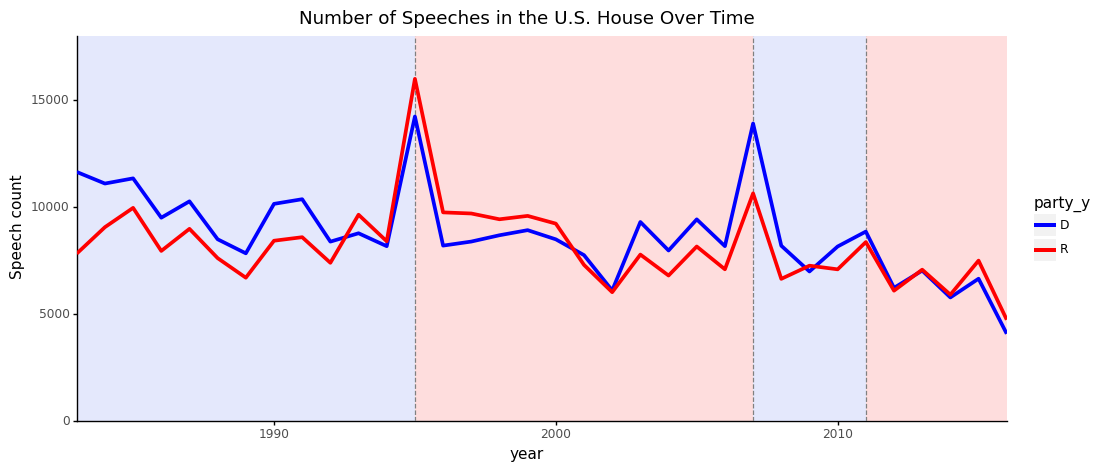

<ggplot: (8744248195413)>

In [26]:
count_df = ldf.groupby(['year','party_y']).count().reset_index()
ymax = max(count_df['speech_id']) + 2000
(
ggplot(count_df,aes(x = 'year', y='speech_id',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=ymax,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=ymax,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=ymax,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Speech count') +
    ggtitle("Number of Speeches in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

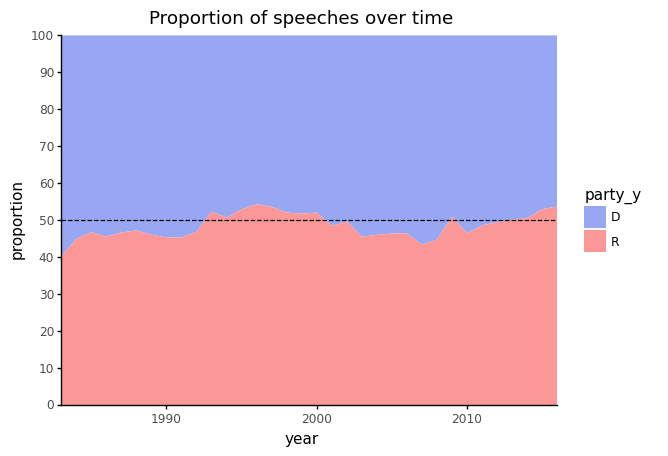

<ggplot: (8744247928573)>

In [27]:

yearly_count = ldf.groupby(['year','party_y']).agg({'party_x':'count'})
prop_speeches = yearly_count.groupby(level=0).apply(lambda x: 100*x/float(x.sum())).reset_index()

(
    ggplot(prop_speeches,aes(x='year',y='party_x',fill='party_y')) + 
    geoms.geom_area(stat='identity') +
    scales.scale_fill_manual(values=['#98a7f2','#fc9797']) +
    annotate('segment',x=1983,xend=2016,y=50,yend=50,color='black',linetype='dashed') +
    scales.scale_y_continuous(breaks=[0,10,20,30,40,50,60,70,80,90,100],expand=[0,0]) +
    theme(panel_background=element_blank(),
          axis_line=element_line()
         ) +
    scales.scale_x_continuous(expand=(0,0)) +
    ylab('proportion') +
    ggtitle('Proportion of speeches over time')
)

### Iterrogating spikes in speech frequency

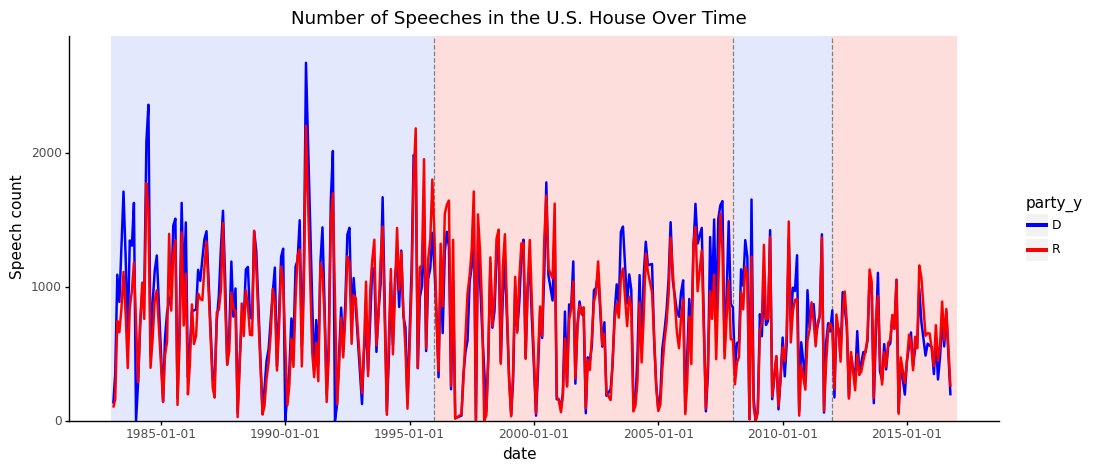

<ggplot: (-9223363292608690516)>

In [28]:
ldf_m = ldf[['speaker','party_y','date','speech_text']]
ldf_m.index = pd.to_datetime(ldf_m['date'])
ldf_m = ldf_m.groupby([pd.Grouper(freq='M'),'party_y']).speech_text.count().reset_index()

ymax = max(ldf_m['speech_text']) + 200

(
ggplot(ldf_m,aes(x = 'date', y='speech_text',color='party_y')) + 
        annotate('rect',xmin=pd.to_datetime('1983-01-01'),xmax=pd.to_datetime('1995-12-31'),ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
        annotate('rect',xmin=pd.to_datetime('1995-12-31'),xmax=pd.to_datetime('2007-12-31'),ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
        annotate('rect',xmin=pd.to_datetime('2007-12-31'),xmax=pd.to_datetime('2011-12-31'),ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
        annotate('rect',xmin=pd.to_datetime('2011-12-31'),xmax=pd.to_datetime('2016-12-31'),ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
        annotate('segment',x=pd.to_datetime('1995-12-31'),xend=pd.to_datetime('1995-12-31'),y=0,yend=ymax,color='grey',linetype='dashed') + 
        annotate('segment',x=pd.to_datetime('2007-12-31'),xend=pd.to_datetime('2007-12-31'),y=0,yend=ymax,color='grey',linetype='dashed') + 
        annotate('segment',x=pd.to_datetime('2011-12-31'),xend=pd.to_datetime('2011-12-31'),y=0,yend=ymax,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Speech count') +
    ggtitle("Number of Speeches in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) 

)

In [29]:
indiv_count = ldf.groupby(['year','speaker','party_y']).count().reset_index()

In [30]:
indiv_avg = indiv_count.groupby(['year','party_y']).speech_id.mean().reset_index()
indiv_sd = indiv_count.groupby(['year','party_y']).speech_id.std().reset_index()

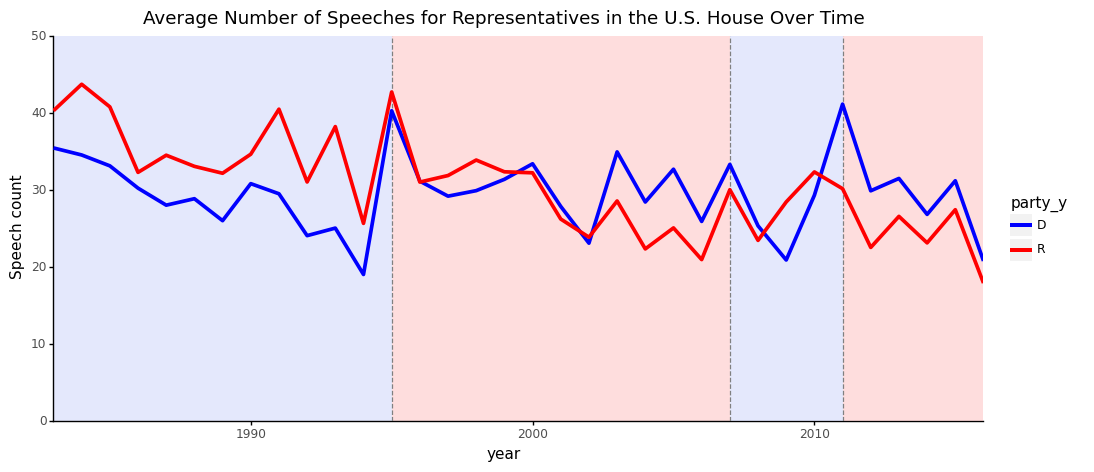

<ggplot: (-9223363292608561341)>

In [31]:
count_df = ldf.groupby(['year','party_y']).count().reset_index()
ymin = min(indiv_avg['speech_id'])
ymax = max(indiv_avg['speech_id'])

(
ggplot(indiv_avg,aes(x = 'year', y='speech_id',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=50,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=50,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=50,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=50,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=50,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=50,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=50,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Speech count') +
    ggtitle("Average Number of Speeches for Representatives in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

### Who gave the most speeches in each party each year?

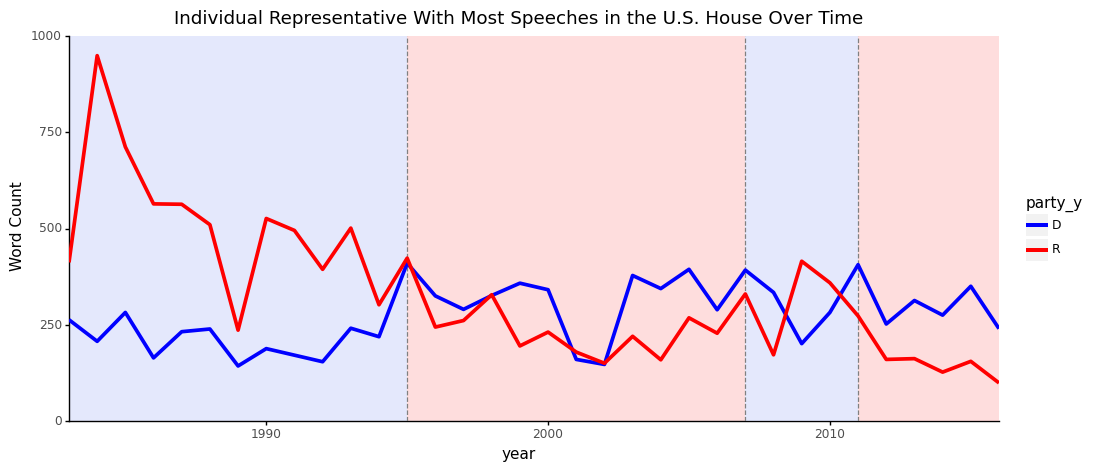

<ggplot: (8744254059240)>

In [32]:
idx = indiv_count.groupby(['year','party_y'])['speech_id'].transform(max) == indiv_count['speech_id']
max_speeches = indiv_count[idx][['year','speaker','party_y','speech_text']]

(
ggplot(max_speeches,
       aes(x = 'year', y='speech_text',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=1000,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Word Count') +
    ggtitle("Individual Representative With Most Speeches in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

In [57]:
max_speeches

,year,speaker,party_y,speech_text
432,1983,Mr. WALKER,R,412
455,1983,Mr. WRIGHT,D,263
952,1984,Mr. WALKER,R,949
978,1984,Mr. WRIGHT,D,207
1226,1985,Mr. FRANK,D,282
...,...,...,...,...
18328,2014,Ms. JACKSON LEE,D,275
18703,2015,Mr. THOMPSON of Pennsylvania,R,155
18802,2015,Ms. JACKSON LEE,D,350
19179,2016,Mr. THOMPSON of Pennsylvania,R,99


In [60]:
max_speeches.pivot(index='year',columns='party_y',values=['speaker','speech_text'])

speaker                               speech_text  \
party_y                           D                             R           D   
year                                                                            
1983                     Mr. WRIGHT                    Mr. WALKER         263   
1984                     Mr. WRIGHT                    Mr. WALKER         207   
1985                      Mr. FRANK                    Mr. WALKER         282   
1986                      Mr. FOLEY                    Mr. WALKER         164   
1987                      Mr. FRANK                    Mr. WALKER         232   
1988                      Mr. VENTO                    Mr. WALKER         239   
1989                  Mr. TRAFICANT                    Mr. WALKER         143   
1990                  Mr. TRAFICANT                    Mr. WALKER         188   
1991                    Mr. PANETTA                    Mr. WALKER         171   
1992                    Mr. MAZZOLI                    Mr. WALKER         154   
1993                     Mr. BONIOR                    Mr. WALKER         241   
1994                  Mr. TRAFICANT                    Mr. WALKER         219   
1995                 Mrs. SCHROEDER                   Mr. SOLOMON         410   
1996                    Mr. PALLONE                  Mr. KINGSTON         325   
1997                    Mr. PALLONE                   Mr. SOLOMON         290   
1998       Ms. JACKSON-LEE of Texas                   Mr. SOLOMON         326   
1999       Ms. JACKSON-LEE of Texas                  Mr. SCHAFFER         358   
2000                       Mr. OBEY                    Mr. GILMAN         341   
2001                    Mr. PALLONE                    Mr. THOMAS         160   
2002                    Mr. PALLONE                     Mr. ARMEY         147   
2003       Ms. JACKSON-LEE of Texas                     Mr. DELAY         378   
2004       Ms. JACKSON-LEE of Texas                     Mr. DELAY         344   
2005       Ms. JACKSON-LEE of Texas                   Mr. GINGREY         394   
2006               Mr. RYAN of Ohio                   Mr. GINGREY         289   
2007       Ms. JACKSON-LEE of Texas          Mr. PRICE of Georgia         392   
2008       Ms. JACKSON-LEE of Texas                       Mr. POE         334   
2009     Mr. FRANK of Massachusetts                      Mr. AKIN         201   
2010                  Mr. GARAMENDI                      Mr. AKIN         282   
2011       Ms. JACKSON LEE of Texas                    Mr. DREIER         406   
2012       Ms. JACKSON LEE of Texas    Mr. HASTINGS of Washington         252   
2013                Ms. JACKSON LEE                      Ms. FOXX         313   
2014                Ms. JACKSON LEE    Mr. HASTINGS of Washington         275   
2015                Ms. JACKSON LEE  Mr. THOMPSON of Pennsylvania         350   
2016                Ms. JACKSON LEE  Mr. THOMPSON of Pennsylvania         240   

              
party_y    R  
year          
1983     412  
1984     949  
1985     712  
1986     564  
1987     563  
1988     510  
1989     236  
1990     526  
1991     495  
1992     394  
1993     501  
1994     302  
1995     423  
1996     244  
1997     261  
1998     328  
1999     195  
2000     231  
2001     179  
2002     150  
2003     220  
2004     159  
2005     268  
2006     228  
2007     330  
2008     172  
2009     415  
2010     359  
2011     273  
2012     160  
2013     162  
2014     127  
2015     155  
2016      99

### Average speech length for the representatives with the most speeches

In [41]:
ldf.word_count.median()

246.0

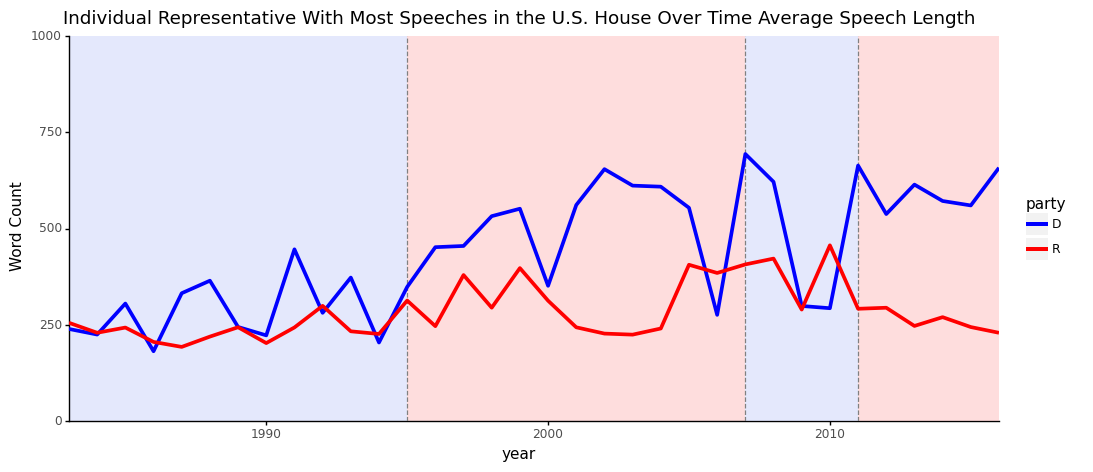

<ggplot: (-9223363292608109522)>

In [63]:
def get_summary_max_speaker(x):
    mean = ldf.loc[(ldf.year == x.year) & (ldf.speaker == x.speaker)].word_count.mean()
    median = ldf.loc[(ldf.year == x.year) & (ldf.speaker == x.speaker)].word_count.median()
    row = {"speaker":x.speaker,'year':x.year,'party':x.party_y,'mean':mean,'median':median}
    return row

max_speaker_avg_length_df = pd.DataFrame(list(max_speeches.apply(get_summary_max_speaker,1)))

(
ggplot(max_speaker_avg_length_df,
       aes(x = 'year', y='mean',color='party')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=1000,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Word Count') +
    ggtitle("Individual Representative With Most Speeches in the U.S. House Over Time Average Speech Length") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

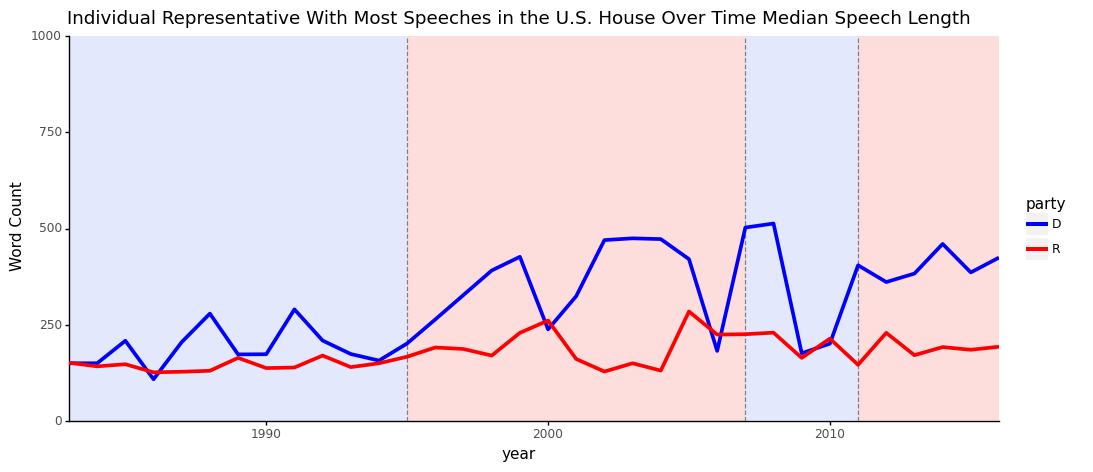

<ggplot: (8744259837381)>

In [64]:

(
ggplot(max_speaker_avg_length_df,
       aes(x = 'year', y='median',color='party')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=1000,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Word Count') +
    ggtitle("Individual Representative With Most Speeches in the U.S. House Over Time Median Speech Length") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

### Proportion of speeches by individuals

In [145]:
(sum_count.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
     .reset_index()
    .groupby('year').apply(lambda x: x.sort_values('speech_id',ascending=False))
    .drop('year',1)
    .reset_index()
    .groupby('year').head(5))


,year,level_1,speaker,speech_id
0,1983,432,Mr. WALKER,2.118252
1,1983,455,Mr. WRIGHT,1.352185
2,1983,167,Mr. FRENZEL,1.187661
3,1983,381,Mr. SEIBERLING,1.084833
4,1983,103,Mr. CONTE,1.069409
...,...,...,...,...
18855,2016,19272,Ms. JACKSON LEE,2.725414
18856,2016,19114,Mr. POLIS,1.510334
18857,2016,19064,Mr. MCGOVERN,1.260504
18858,2016,19179,Mr. THOMPSON of Pennsylvania,1.124233


In [149]:
pct_top_5_speakers

,year,level_1,speaker,speech_id
0,1983,432,Mr. WALKER,2.118252
1,1983,455,Mr. WRIGHT,1.352185
2,1983,167,Mr. FRENZEL,1.187661
3,1983,381,Mr. SEIBERLING,1.084833
4,1983,103,Mr. CONTE,1.069409
...,...,...,...,...
18855,2016,19272,Ms. JACKSON LEE,2.725414
18856,2016,19114,Mr. POLIS,1.510334
18857,2016,19064,Mr. MCGOVERN,1.260504
18858,2016,19179,Mr. THOMPSON of Pennsylvania,1.124233


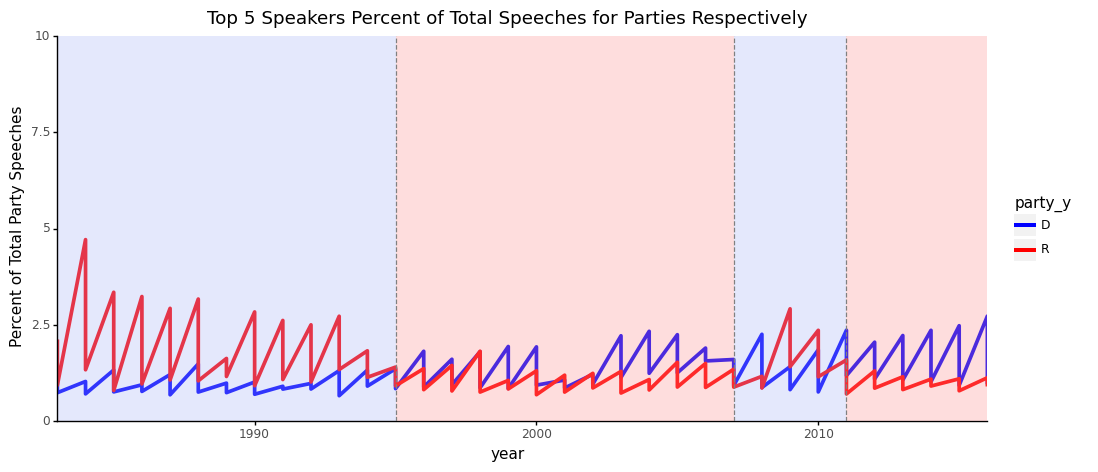

<ggplot: (8744246153392)>

In [155]:
sum_count = indiv_count.groupby(['year','party_y','speaker']).agg({'speech_id': 'sum'})
pct_top_5_speakers = (sum_count.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
     .reset_index()
    .groupby(['year','party_y']).apply(lambda x: x.sort_values('speech_id',ascending=False))
    .drop(['year','party_y'],1)
    .reset_index()
    .groupby(['year','party_y']).head(5))
(
ggplot(pct_top_5_speakers,
       aes(x = 'year', y='speech_id',color='party_y')) + 
    geoms.geom_line(size=1.5) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Percent of Total Party Speeches') +
    ggtitle("Top 5 Speakers Percent of Total Speeches for Parties Respectively") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0]) + 
    scales.scale_color_manual(values=['Blue','Red']) +
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=10,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=10,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=10,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=10,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=10,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=10,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=10,color='grey',linetype='dashed')
)

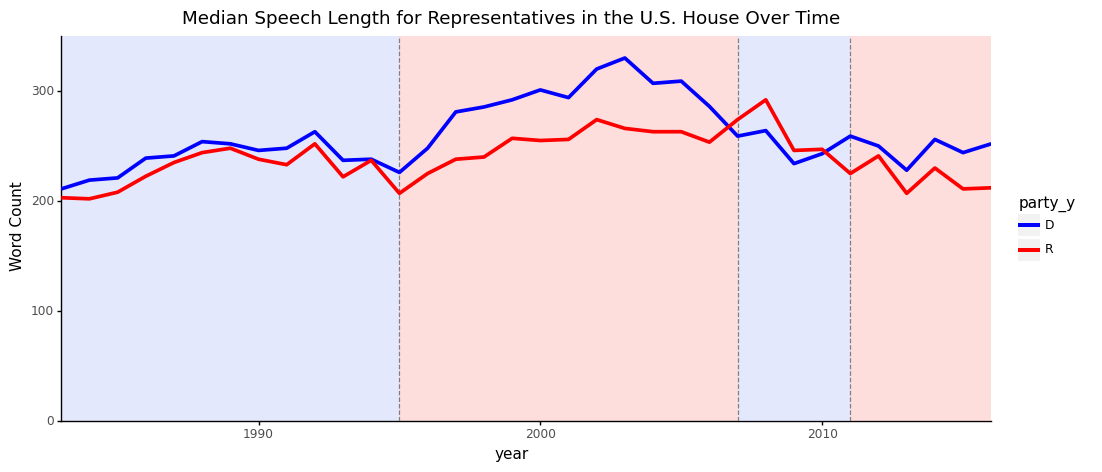

<ggplot: (-9223363292594616295)>

In [35]:

(
ggplot(ldf.groupby(['year','party_y']).word_count.median().reset_index(),
       aes(x = 'year', y='word_count',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=350,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=350,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=350,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=350,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=350,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=350,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=350,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Word Count') +
    ggtitle("Median Speech Length for Representatives in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)